# Import

In [1]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Categorical
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time

#Setting up matplotlib for live update the traiing progress
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# Test env

  0%|          | 0/10 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 10/10 [00:00<00:00, 150.18it/s]


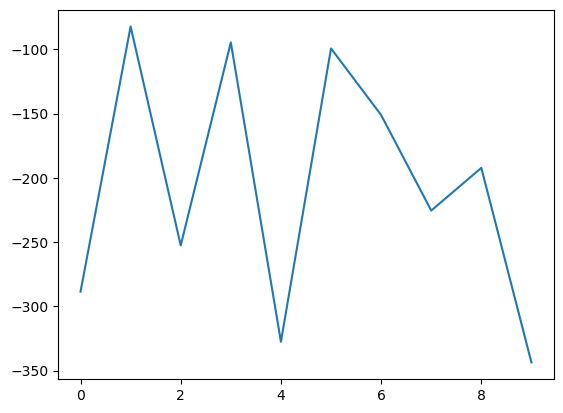

In [2]:
env = gym.make('LunarLander-v2')
obs, info = env.reset()

rewards = []
for ep in tqdm(range(10)):
    obs, info = env.reset()
    total_reward = 0

    for t in count():
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated: 
            break
    
    rewards.append(total_reward)

sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.show()
env.close()

# Model

In [3]:
class ActorNet(nn.Module):

    def __init__(self, state_size, action_size, hidden_size = 128) -> None:
        super().__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(state_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size * 2)
        self.linear3 = nn.Linear(hidden_size * 2, action_size)

    def forward(self, X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = F.softmax(self.linear3(X))
        return Categorical(X)


class CriticNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size = 128) -> None:
        super().__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(state_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size * 2)
        self.linear3 = nn.Linear(hidden_size * 2, 1)

    def forward(self, X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        return self.linear3(X)


In [4]:
# Test model
env = gym.make('LunarLander-v2')
state, info = env.reset()

obs_space = len(state)
action_space = env.action_space.n
print('obs space = ', obs_space, ' action space = ', action_space)

state = torch.tensor(state).float().unsqueeze(0)
print(state.shape)

actor = ActorNet(8, 4)
critic = CriticNet(8, 4)

print('actor output =', actor(state))
print('critic output =', critic(state))

env.close()

obs space =  8  action space =  4
torch.Size([1, 8])
actor output = Categorical(probs: torch.Size([1, 4]))
critic output = tensor([[0.0200]], grad_fn=<AddmmBackward0>)


# Compute reward function

NOTE: research more

In [5]:
#NOTE: research more
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

# OUTPUT folder

In [6]:
DEVICE = "cpu"
ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output','lunar')

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)

# Tune

In [7]:
def tune(actor, critic, env, lr, device, 
         training_epochs = 100, gamma = 0.99, 
         label = 'baseline', plot_update_freq = 50):

    #preparing save folder
    
    SAVE_PATH = os.path.join(OUTPUT, label)
    FIG_SAVE_PATH = os.path.join(SAVE_PATH, 'plot.png')
    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)

    #optim
    optimA = torch.optim.Adam(actor.parameters(), lr = lr)
    optimC = torch.optim.Adam(critic.parameters(), lr = lr)

    loop = tqdm(range(training_epochs))

    history = defaultdict(list)
    best_avg_reward = -float('inf')

    reward_window = deque(maxlen=100) 

    for epoch in loop:
        state, info = env.reset()
        log_probs = []
        values = []
        rewards = []
        dones = []
        entropy = 0
        done = False

        total_reward = 0

        for t in count():
            state = torch.tensor(state).float().to(device)
            action_prob = actor(state)
            value = critic(state)

            action = action_prob.sample()

            # calculates the logarithm of the probability density function (PDF) 
            # why we need log_prob? 
            log_prob = action_prob.log_prob(action).unsqueeze(0)
            log_probs.append(log_prob)

            action = action.cpu().numpy()
            next_state, reward, terminated, truncated, info = env.step(action)

            total_reward += reward

            values.append(value)

            reward = torch.tensor([reward]).float().to(device)
            rewards.append(reward)

            done = terminated or truncated

            dones.append(torch.tensor([1 - done]).float().to(device))
            state = next_state

            if done:
                #epsiode terminated
                break

        next_state = torch.tensor(next_state).float().to(device)
        next_state_value = critic(next_state)
        returns = compute_returns(next_state_value, rewards, dones, gamma)
        
        log_probs = torch.cat(log_probs)
        values = torch.cat(values)
        returns = torch.cat(returns).detach()

        advantage = returns - values

        # reference
        # https://pytorch.org/docs/stable/distributions.html
        # the minus because of gradient ascend
        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        optimA.zero_grad()
        optimC.zero_grad()

        actor_loss.backward()
        critic_loss.backward()

        optimA.step()
        optimC.step()

        #update score
        reward_window.append(total_reward)
        avg_reward = np.mean(reward_window)

        if best_avg_reward <= avg_reward:
            best_avg_reward = avg_reward
            #save best model
            torch.save(actor, os.path.join(SAVE_PATH, 'actor.checkpoint.torch'))
            torch.save(critic, os.path.join(SAVE_PATH, 'critic.checkpoint.torch'))
        
        if epoch % plot_update_freq == 0:
            plot(history, save_path = FIG_SAVE_PATH)
        
        history['reward'].append(avg_reward)


        loop.set_description(f'epoch = {epoch}, avg reward = {avg_reward:.2f}, total_reward = {total_reward:.2f}')

    env.close()
    return history

def plot(history, show = False, save_path = None):
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))))

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()
        
    plt.clf()
    plt.close()

# Baseline

In [10]:
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', device)
training_epochs = 10000
gamma = 0.99

env = gym.make('LunarLander-v2')
state,info = env.reset()

state_space = len(state)
action_space= env.action_space.n

actor = ActorNet(state_space, action_space, hidden_size = 128).to(device)
critic = CriticNet(state_space, action_space, hidden_size = 128).to(device)

history = tune(actor, critic, env, lr, device, training_epochs=training_epochs, gamma = gamma, label = 'baseline')
torch.save(actor, 'actor.torch')
torch.save(critic, 'critic.torch')
plot(history)


device =  cpu


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
epoch = 9999, avg reward = 173.74, total_reward = 246.93: 100%|██████████| 10000/10000 [2:11:46<00:00,  1.26it/s]  


# Exp 3, increase hidden size to 256

In [ ]:
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', device)
training_epochs = 10000
gamma = 0.99

env = gym.make('LunarLander-v2')
state,info = env.reset()

state_space = len(state)
action_space= env.action_space.n

actor = ActorNet(state_space, action_space, hidden_size = 256).to(device)
critic = CriticNet(state_space, action_space, hidden_size = 256).to(device)

history = tune(actor, critic, env, lr, device, training_epochs=training_epochs, gamma = gamma, label = 'exp3')
# torch.save(actor, 'actor.torch')
# torch.save(critic, 'critic.torch')
plot(history)


# Run the agent

In [20]:
# nv = gym.make('CartPole-v1')
env = gym.make('LunarLander-v2')

# net = torch.load('best_target_net.torch')
LOAD_PATH = os.path.join(OUTPUT, 'exp3', 'actor.checkpoint.torch')
eval_net = torch.load(LOAD_PATH)

loop = tqdm(range(100))
total_rewards = []

for epoch in loop:
    state, info = env.reset()
    total_reward = 0

    for step in count():
        state = torch.tensor(state).float()
        action_dist = eval_net(state)
        action = action_dist.sample()

        next_state, reward, terminated, truncated, info = env.step(action.numpy())
        state = next_state
        total_reward += reward
        state = next_state

        if terminated or truncated:
            break
    
    total_rewards.append(total_reward)

    loop.set_description(f'ep = {epoch}, reward = {total_reward}')
    
sns.lineplot(y = total_rewards, x= list(range(len(total_reward))))
env.close()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
ep = 14, reward = 269.3971282324024:  15%|█▌        | 15/100 [00:05<00:30,  2.81it/s] 


KeyboardInterrupt: 

# Human render

In [19]:
# nv = gym.make('CartPole-v1')
env = gym.make('LunarLander-v2', render_mode = 'human')

# net = torch.load('best_target_net.torch')
LOAD_PATH = os.path.join(OUTPUT, 'exp3', 'actor.checkpoint.torch')
eval_net = torch.load(LOAD_PATH)

loop = tqdm(range(10))
total_rewards = []

for epoch in loop:
    state, info = env.reset()
    total_reward = 0

    for step in count():
        state = torch.tensor(state).float()
        action_dist = eval_net(state)
        action = action_dist.sample()

        next_state, reward, terminated, truncated, info = env.step(action.numpy())
        state = next_state
        total_reward += reward
        state = next_state

        if terminated or truncated:
            break
    
    total_rewards.append(total_reward)

    loop.set_description(f'ep = {epoch}, reward = {total_reward}')
    rewards.append(total_reward)
    
sns.lineplot(y = total_rewards, x= list(range(len(total_reward))))
env.close()

  0%|          | 0/10 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
ep = 0, reward = 289.3318779143277:  10%|█         | 1/10 [00:25<03:48, 25.33s/it]


KeyboardInterrupt: 

# Extra Experiment

In [65]:
lr = 1e-3
device = 'cpu'
training_epochs = 500
gamma = 0.99

env = gym.make('CartPole-v1')
state,info = env.reset()

state_space = len(state)
action_space= env.action_space.n

actor = ActorNet(state_space, action_space).to(device)
critic = CriticNet(state_space, action_space).to(device)

history = tune(actor, critic, env, lr, device, training_epochs=training_epochs, gamma = gamma, label = 'test')
torch.save(actor, 'actor.torch')
torch.save(critic, 'critic.torch')
plot(history)


epoch = 116, avg reward = 51.79, total_reward = 126.0:  23%|██▎       | 117/500 [00:08<00:27, 13.93it/s]


KeyboardInterrupt: 